In [1]:
import dask
import numpy
import starepandas
import geopandas
import pystare
import matplotlib.pyplot as plt

In [2]:
us = geopandas.read_file('data/tl_2017_us_state/tl_2017_us_state.shp')
us = us.to_crs('EPSG:4326')
len(us)

56

# SIDs

In [4]:
# Manual parallel sids lookup
n_cores = 55
ddf = dask.dataframe.from_pandas(us.geometry, npartitions=n_cores)
meta = {'stare': 'int64'}

res = ddf.map_partitions(lambda df: numpy.array(starepandas.stare_from_geoseries(df, 7)), meta=meta)
stare = res.compute(scheduler='processes')

In [3]:
# High level
stare = starepandas.stare_from_geoseries(us.geometry, level=7, nonconvex=True, force_ccw=True, n_workers=55)

In [4]:
us['stare'] = stare

# Trixels

In [5]:
n_cores = 55

ddf = dask.dataframe.from_pandas(us['stare'], npartitions=n_cores)
meta = {'trixels': 'object'}

res = ddf.map_partitions(lambda df: numpy.array(starepandas.trixels_from_stareseries(df)), meta=meta)
trixels = res.compute(scheduler='processes')

In [7]:
trixels = starepandas.trixels_from_stareseries(us.stare, n_workers=55)

In [8]:
us['trixels'] = trixels

# Visualization

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,stare,trixels
31,4,9,15,01779782,15,HI,Hawaii,00,G4000,A,16634117742,11777681513,+22.0120383,-159.7059653,"MULTIPOLYGON (((-166.38653 23.84636, -166.3842...","[1158902847861948423, 1159149138466570247, 115...",(POLYGON ((-165.7746047773546 23.5351684087914...


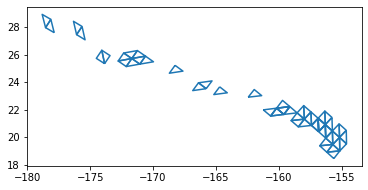

In [9]:
sdf = starepandas.STAREDataFrame(us, stare='stare', trixels='trixels')
sdf.iloc[31:32].plot(trixels=True)
sdf.iloc[31:32]

In [3]:
sdf = starepandas.STAREDataFrame(us, add_stare=True, level=7, add_trixels=True, n_workers=55)

<AxesSubplot:>

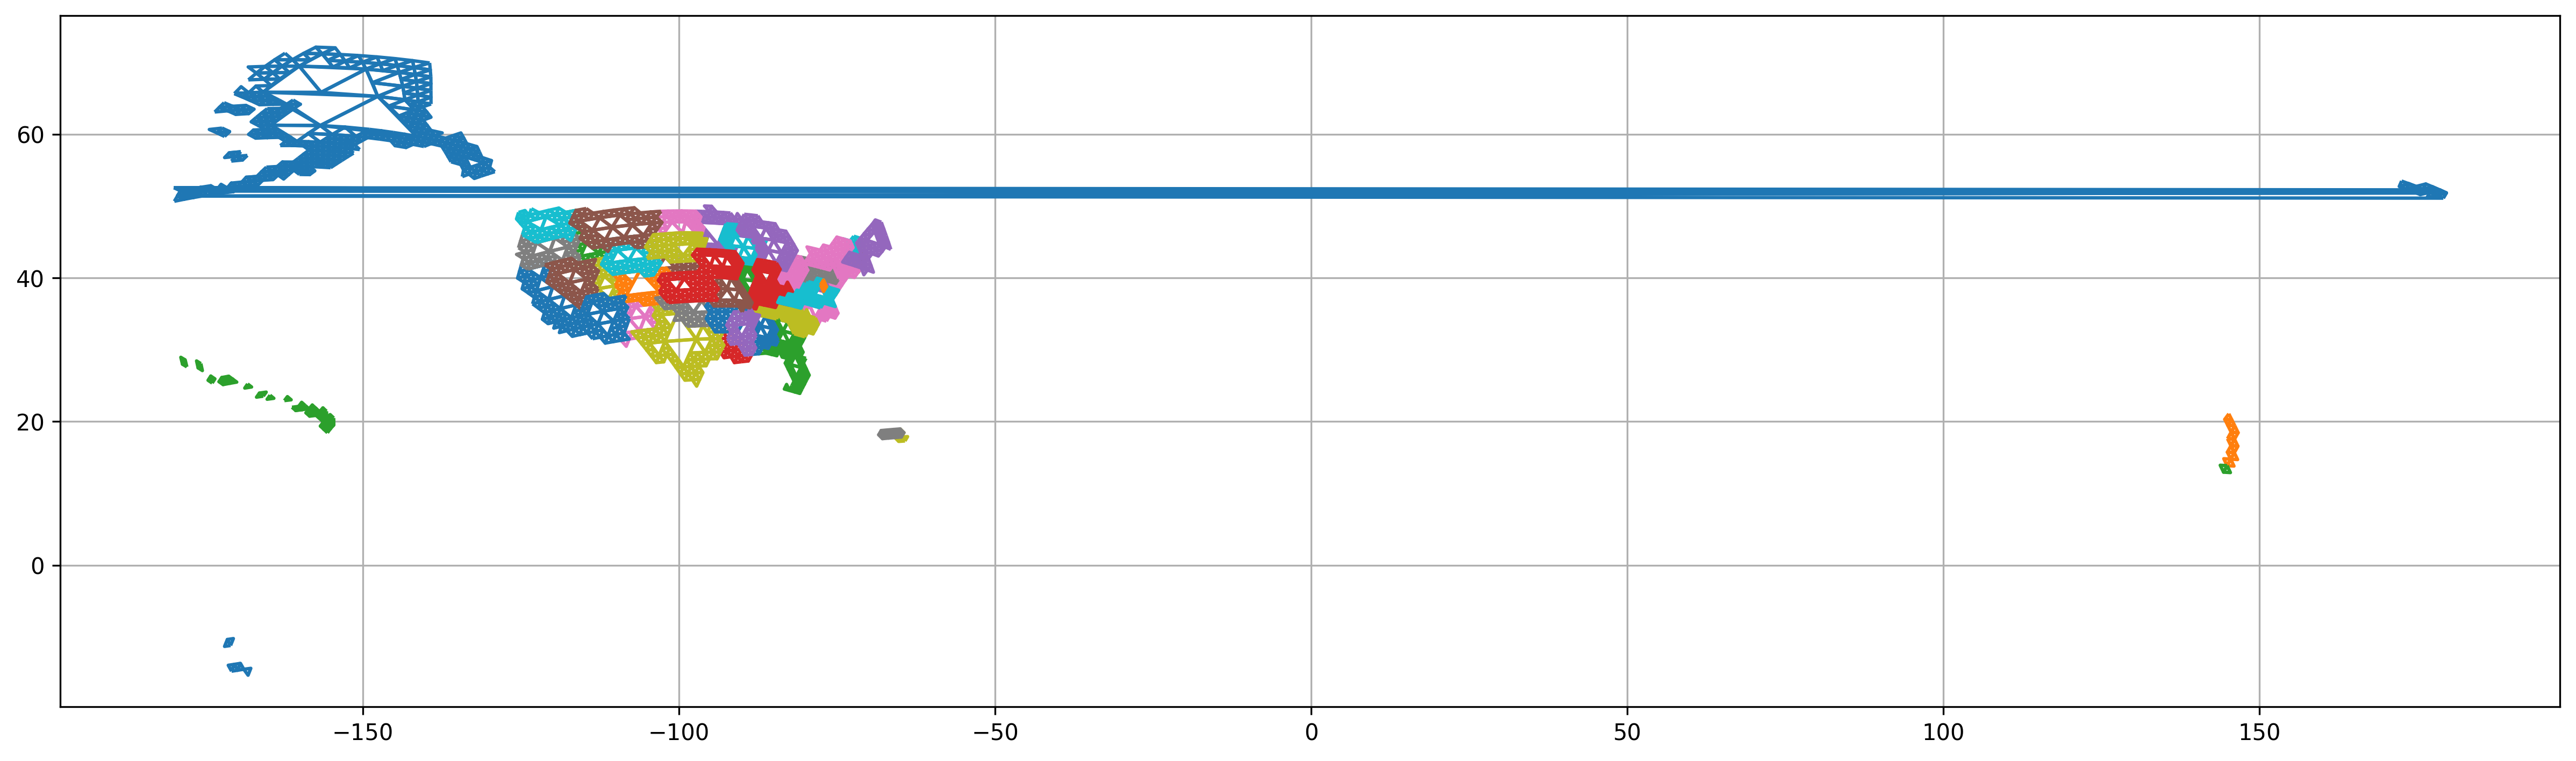

In [14]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300)
ax.grid(True)

sdf.plot(ax=ax, trixels=True, column='NAME')